### F1 winner predictor project

This project's aim is to develop a model that predicts the F1 next race winner and deploy it to a k8s cluster.

In [ ]:
!pip install kagglehub[pandas-datasets]

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jtrotman/formula-1-race-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/formula-1-race-data


###Minimal subset for a “who wins the race?” model
* results.csv – holds the target (position = 1)
* qualifying.csv – starting grid; a huge signal
* drivers.csv + constructors.csv – static categorical features
* driver_standings.csv / constructor_standings.csv – momentum features (points  before the race)
* races.csv + circuits.csv – track, round number, season context


Goal: For every (race, driver) pair, output P(win) and pick the driver with the highest probability as the predicted winner.

 ### Feature engineering (plain pandas)

In [13]:
# =========================================================
# Formula-1 dataset → feature table (per driver–race row)
# =========================================================
import pandas as pd

# ---- CONFIG -------------------------------------------------------------
PATH  = "/kaggle/input/formula-1-race-data/"   # change if needed
NULLS = ['\\N', '']                            # Ergast NA tokens

# ---- 1. Load CSVs --------------------------------------------------------
races       = pd.read_csv(f"{PATH}races.csv",       na_values=NULLS, parse_dates=['date'])
drivers     = pd.read_csv(f"{PATH}drivers.csv",     na_values=NULLS, parse_dates=['dob'])
results     = pd.read_csv(f"{PATH}results.csv",     na_values=NULLS)
qualifying  = pd.read_csv(f"{PATH}qualifying.csv",  na_values=NULLS)
constructors = pd.read_csv(f"{PATH}constructors.csv", na_values=NULLS)
d_standings = pd.read_csv(f"{PATH}driver_standings.csv", na_values=NULLS)

# ---- 2. Clean numeric columns & create winner flag ----------------------
results['position'] = pd.to_numeric(results['position'], errors='coerce')
results['grid']     = pd.to_numeric(results['grid'],     errors='coerce')
results['winner']   = (results['position'] == 1).astype(int)

# ---- 3. Merge qualifying lap times (q1–q3) + qual position -------------
q_cols = ['raceId', 'driverId', 'q1', 'q2', 'q3', 'position']  # 'position' = qual rank
df = results.merge(qualifying[q_cols], on=['raceId', 'driverId'], how='left') \
            .rename(columns={'position': 'qual_pos'})

# --- 3. Merge qualifying lap times + quali-position --------------------
q_cols = ['raceId', 'driverId', 'q1', 'q2', 'q3', 'position']  # 'position' = qual rank
df = results.merge(
        qualifying[q_cols],
        on=['raceId', 'driverId'],
        how='left',
        suffixes=('', '_qual')       # <-- keeps results columns unchanged
)

df = df.rename(columns={'position_qual': 'qual_pos',   # qualifying P-number
                        'position':      'finish_pos'}) # race result P-number

# ---- 4. Add race & driver metadata --------------------------------------
df = df.merge(races[['raceId', 'date', 'year', 'round', 'circuitId']],
              on='raceId', how='left') \
       .merge(drivers[['driverId', 'dob', 'nationality']],
              on='driverId', how='left')

df['age'] = ((df['date'] - df['dob']).dt.days // 365).astype('Int16')

# ---- 5. Add season-to-date driver points --------------------------------
d_stand_prev = (
    d_standings
      .merge(races[['raceId', 'year', 'round']], on='raceId')
      .rename(columns={'points': 'season_pts'})
)
df = df.merge(d_stand_prev[['raceId', 'driverId', 'season_pts']],
              on=['raceId', 'driverId'], how='left')



### Experimenting with the data.
1. Class balance - how many winers do we have
2. Starting-grid position vs chance of winning.
3. Age distribution - winners vs non-winners
4. Season momentum - points before the race
5. Quick correlation heat-map of numeric features

#####1. Class balance - how many winers do we have

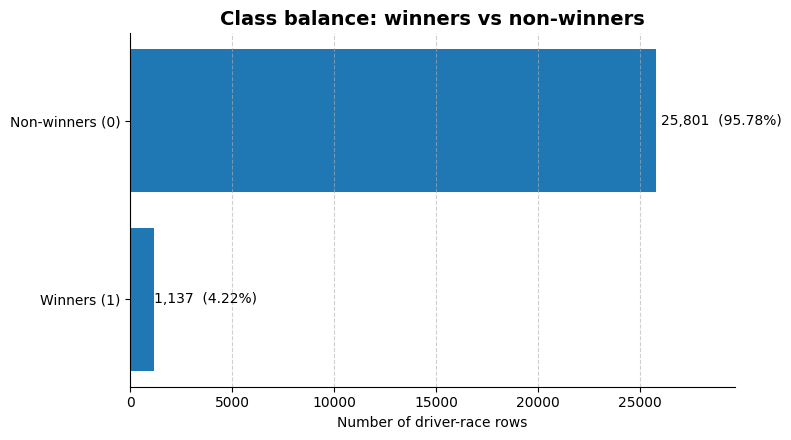

In [14]:
import matplotlib.pyplot as plt

# -- 1.  get the class counts safely -----------------------------------------

win_counts = (
    results['winner']                       # flag we created earlier
      .value_counts()                       # 0 / 1 counts
      .reindex([0, 1], fill_value=0)        # make sure both bars show
)
total = win_counts.sum()

# -- 2.  draw a cleaner chart -------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))    # a bit wider

bars = ax.barh(['Winners (1)', 'Non-winners (0)'],
               win_counts[::-1].values)     # winners on top

# annotate each bar with count *and* %
for bar, count in zip(bars, win_counts[::-1].values):
    ax.text(count * 1.01,                   # just to the right of the bar
            bar.get_y() + bar.get_height() / 2,
            f'{count:,}  ({count/total:.2%})',
            va='center', fontsize=10)

# styling tweaks (no custom colours – stays in default palette)
ax.set_title('Class balance: winners vs non-winners',
             fontsize=14, weight='bold')
ax.set_xlabel('Number of driver-race rows')
ax.xaxis.grid(True, linestyle='--', alpha=0.6)       # subtle grid
ax.set_xlim(0, win_counts.max() * 1.15)              # head-room for labels

# remove cluttering spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


#####2. Probability of winning by grid position

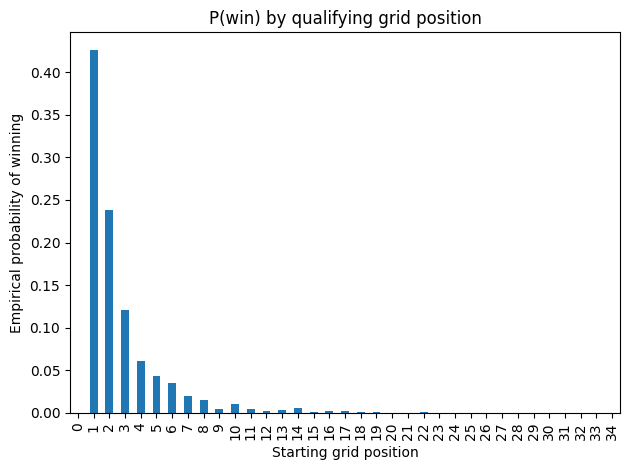

In [15]:
# probability of winning for each grid slot (1-20)
prob_by_grid = df.groupby('grid')['winner'].mean()

plt.figure()
prob_by_grid.plot(kind='bar')
plt.title('P(win) by qualifying grid position')
plt.xlabel('Starting grid position')
plt.ylabel('Empirical probability of winning')
plt.tight_layout()
plt.show()


<ipython-input-16-1e2385cd2e9a>:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data,


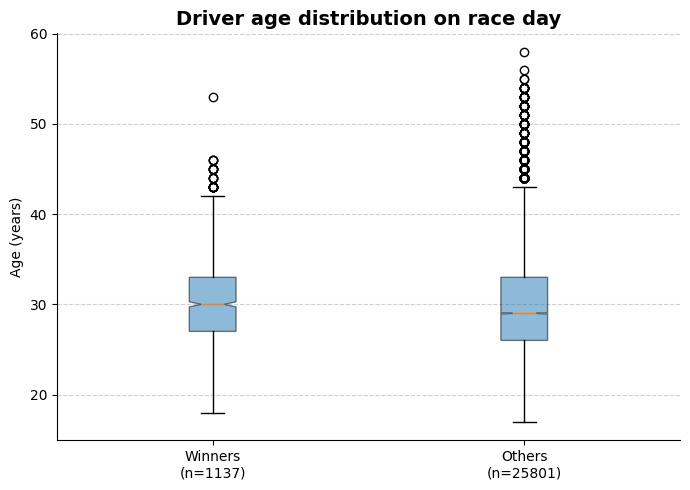

In [16]:
import matplotlib.pyplot as plt

# --- 1. Prep the two age vectors ------------------------------------------
age_win  = df.loc[df['winner'] == 1, 'age'].dropna()
age_lose = df.loc[df['winner'] == 0, 'age'].dropna()

data      = [age_win, age_lose]
labels    = [f'Winners\n(n={len(age_win)})',
             f'Others\n(n={len(age_lose)})']

# --- 2. Beautified box-and-whisker ----------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

box = ax.boxplot(data,
                 labels=labels,
                 notch=True,        # emphasise median diff
                 patch_artist=True) # allow facecolour (default palette)

# Optionally tweak face colours without specifying new colours:
for patch in box['boxes']:
    patch.set_alpha(0.5)

ax.set_title('Driver age distribution on race day', fontsize=14, weight='bold')
ax.set_ylabel('Age (years)')

ax.yaxis.grid(True, linestyle='--', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


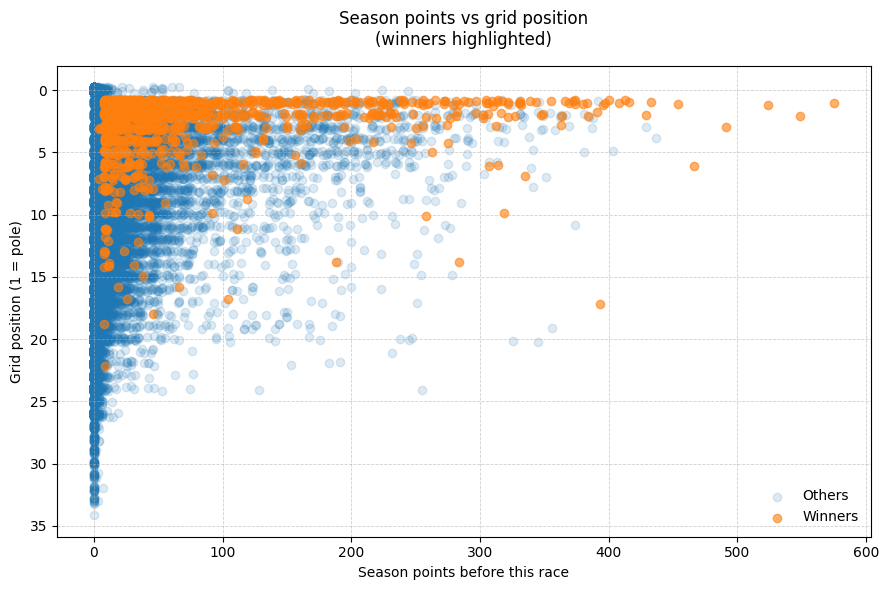

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Split winners / non-winners and add a tiny y-jitter
# ------------------------------------------------------------------
jitter = np.random.uniform(-0.25, 0.25, size=len(df))
y      = df['grid'] + jitter

is_win = df['winner'] == 1
x_win, y_win = df.loc[is_win,  'season_pts'], y[is_win]
x_oth, y_oth = df.loc[~is_win, 'season_pts'], y[~is_win]

# ------------------------------------------------------------------
# 2. Draw scatter plot (default colour cycle, no explicit colours)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(x_oth, y_oth, alpha=0.15, marker='o', label='Others')
ax.scatter(x_win, y_win, alpha=0.6,  marker='o', label='Winners')

ax.invert_yaxis()                      # pole at top
ax.set_xlabel('Season points before this race')
ax.set_ylabel('Grid position (1 = pole)')
ax.set_title('Season points vs grid position\n(winners highlighted)', pad=15)
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

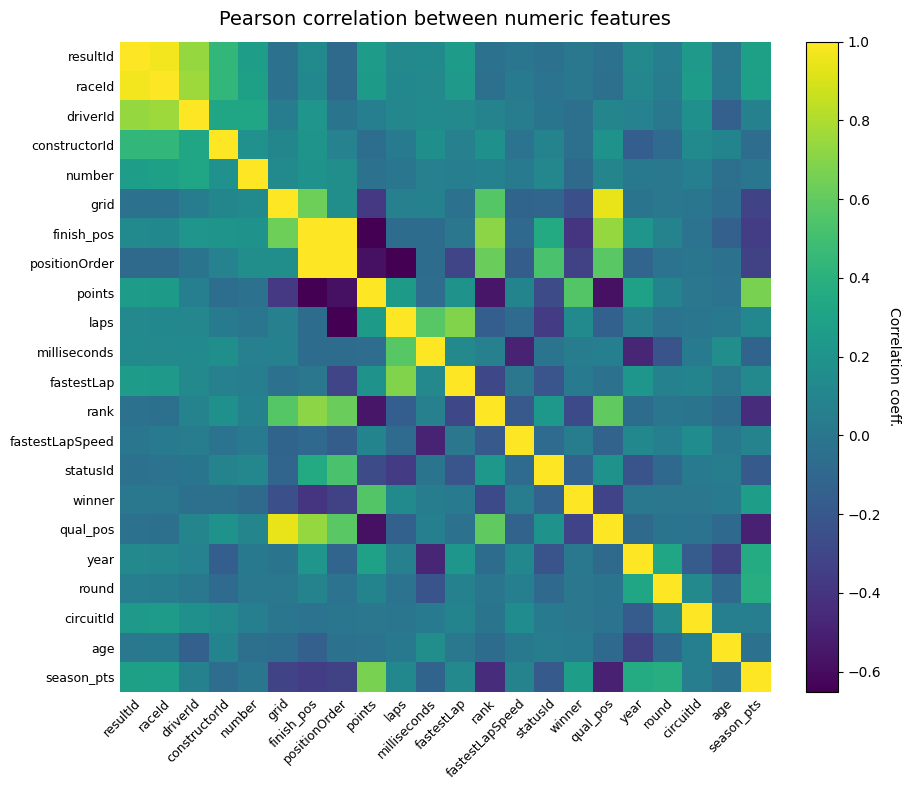

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣  build (or reuse) the correlation matrix
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()

# 2️⃣  draw the heat-map
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, interpolation='nearest')      # default 'viridis' cmap

# 3️⃣  add a colour-bar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation coeff.', rotation=-90, va='bottom')

# 4️⃣  tidy up ticks and labels
ax.set_xticks(np.arange(len(numeric_cols)))
ax.set_yticks(np.arange(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=45, ha='right', rotation_mode='anchor', fontsize=9)
ax.set_yticklabels(numeric_cols, fontsize=9)

# remove spines & tick marks to declutter
for edge in ['top', 'right', 'left', 'bottom']:
    ax.spines[edge].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

# 5️⃣  optionally annotate strong correlations inside the cells
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        coef = corr.iat[i, j]

ax.set_title('Pearson correlation between numeric features', fontsize=14, pad=12)
plt.tight_layout()
plt.show()


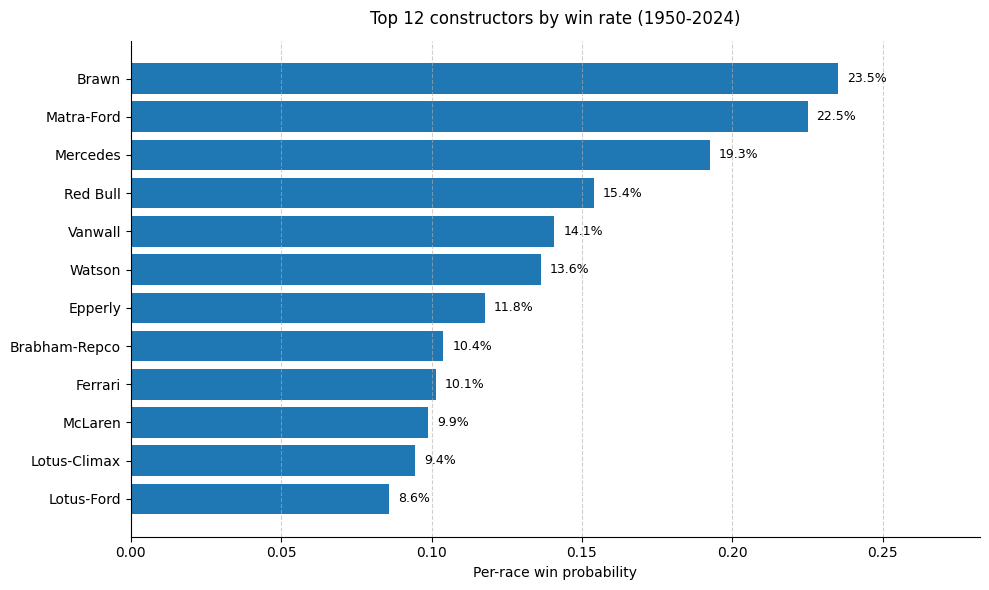

In [19]:
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1.  Build win-rate table and attach readable team names
# ----------------------------------------------------------
win_rate_team = (
    df.groupby('constructorId')['winner'].mean().reset_index()        # P(win) per race
      .merge(constructors[['constructorId', 'name']], on='constructorId')
      .sort_values('winner', ascending=False)
      .head(12)                                   # top 12 teams
)

# ----------------------------------------------------------
# 2.  Horizontal bar chart (best for long labels)
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(
    win_rate_team['name'][::-1],    # reverse so the best is on top
    win_rate_team['winner'][::-1]
)

# add %-labels at the end of each bar
for bar, val in zip(bars, win_rate_team['winner'][::-1]):
    ax.text(
        val + 0.003,                       # nudge right of bar
        bar.get_y() + bar.get_height() / 2,
        f'{val:.1%}',
        va='center', fontsize=9
    )

# styling
ax.set_xlabel('Per-race win probability')
ax.set_title('Top 12 constructors by win rate (1950-2024)', pad=12)
ax.xaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(0, win_rate_team['winner'].max() * 1.2)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


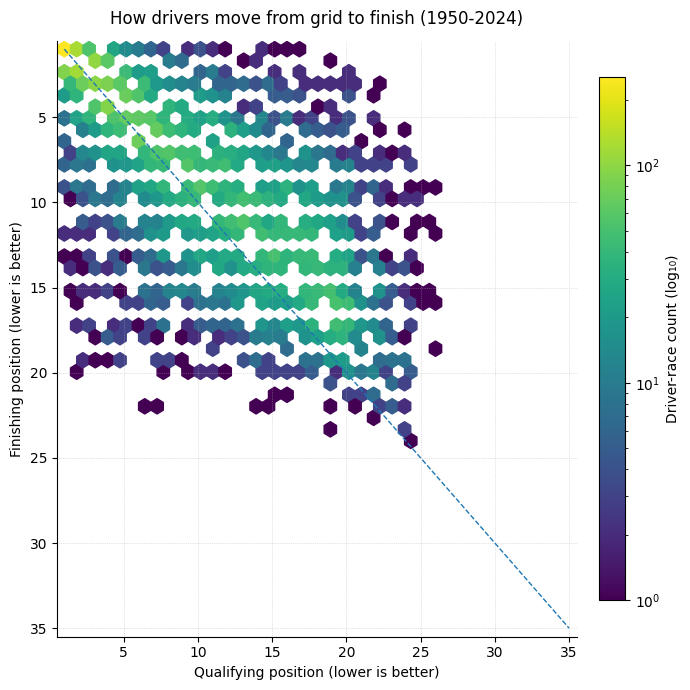

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# --- numeric columns ----------------------------------------------------
qpos = pd.to_numeric(df['qual_pos'],  errors='coerce')
fpos = pd.to_numeric(df['finish_pos'], errors='coerce')

# --- one-shot hexbin chart ---------------------------------------------
fig, ax = plt.subplots(figsize=(7, 7))

hb = ax.hexbin(
        qpos, fpos,
        gridsize=30,        # coarser → bigger hexes, finer → more detail
        bins='log',         # colour encodes log-count; auto-scales nicely
        mincnt=1            # ignore completely empty bins
)

# parity reference line (start-to-finish unchanged)
ax.plot([1, 35], [1, 35], linestyle='--', linewidth=1)

# axis settings
ax.set_xlim(0.5, 35.5)
ax.set_ylim(35.5, 0.5)          # invert y so P1 is up
ax.set_xlabel('Qualifying position (lower is better)')
ax.set_ylabel('Finishing position (lower is better)')
ax.set_title('How drivers move from grid to finish (1950-2024)', pad=12)

# subtle grid + clean spines
ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# colour-bar shows driver-race density (log-scale)
cbar = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Driver-race count (log₁₀)')

plt.tight_layout()
plt.show()


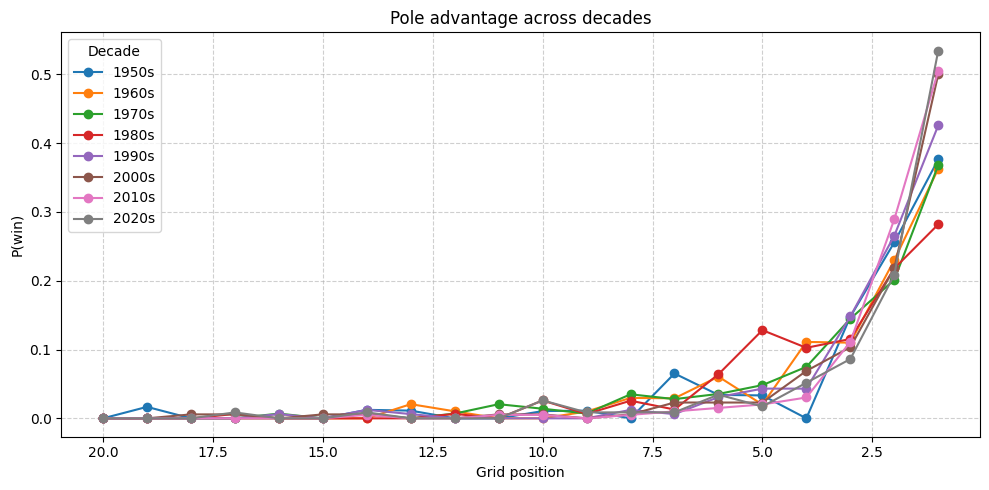

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# add a decade helper if not present
if 'decade' not in df.columns:
    df['decade'] = (df['year'] // 10) * 10    # 1998 → 1990

# compute P(win) per grid within each decade
p_win_dec = (
    df[df['grid'].between(1, 20)]
      .groupby(['decade', 'grid'])['winner']
      .mean()
      .reset_index()
)

# plot
fig, ax = plt.subplots(figsize=(10, 5))
for decade, grp in p_win_dec.groupby('decade'):
    ax.plot(grp['grid'], grp['winner'], marker='o', label=f"{decade}s")

ax.set_xlabel('Grid position')
ax.set_ylabel('P(win)')
ax.set_title('Pole advantage across decades')
ax.invert_xaxis()              # pole on the left if you prefer
ax.legend(title='Decade')
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


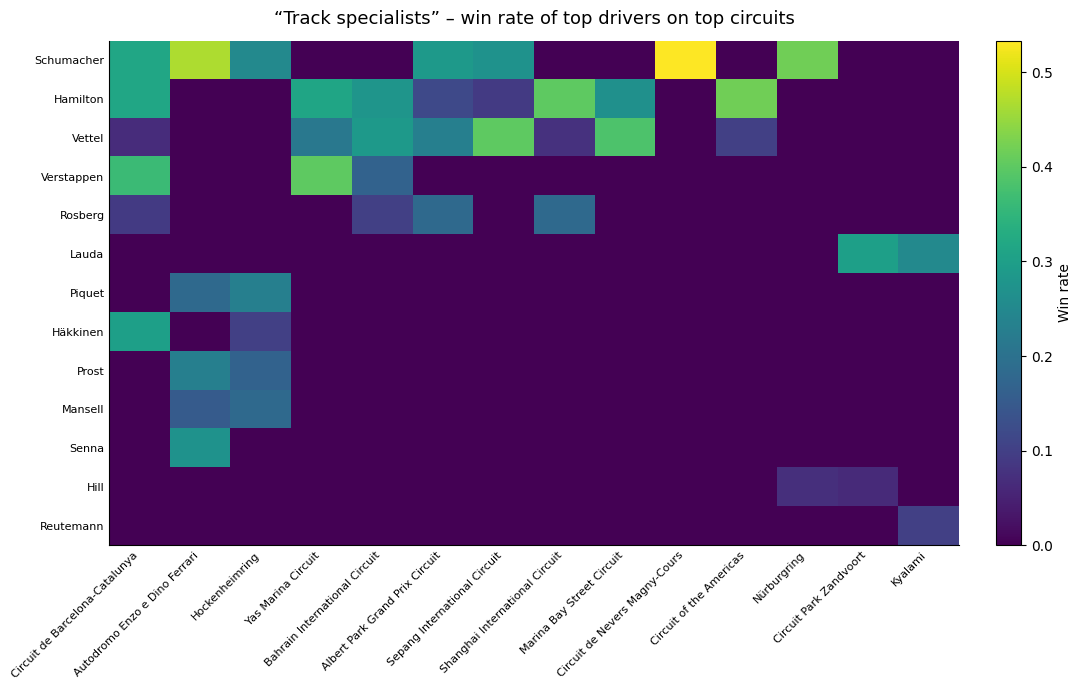

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ───────────────────────── 1  Look-up helpers  ──────────────────────────
try:
    driver_lu = (drivers.assign(name=lambda d: d['surname'])
                         .set_index('driverId')['name'])
except NameError:
    driver_lu = pd.Series(dtype=str)

try:
    circuits_csv = pd.read_csv(f"{PATH}circuits.csv", na_values=NULLS)
    circuit_lu  = circuits_csv.set_index('circuitId')['name']
except Exception:
    circuit_lu = pd.Series(dtype=str)

# ───────────────────────── 2  Build raw win matrix ───────────────────────
win_mat = (
    df.groupby(['driverId', 'circuitId'])['winner']
      .agg(['mean', 'count'])
      .rename(columns={'mean': 'win_rate', 'count': 'starts'})
      .query('starts >= 10')               # keep only reliable cells
      .reset_index()
)

# ───────────────────────── 3  Top-N selection  ───────────────────────────
top_drivers  = (win_mat.groupby('driverId')['win_rate']
                       .mean()
                       .nlargest(15)
                       .index)

top_circuits = (win_mat.groupby('circuitId')['win_rate']
                       .mean()
                       .nlargest(15)
                       .index)

subset = win_mat[win_mat['driverId'].isin(top_drivers) &
                 win_mat['circuitId'].isin(top_circuits)]

heat = (subset
        .pivot(index='driverId', columns='circuitId', values='win_rate')
        .fillna(0))

# --- AFTER pivot: intersect again so we only sort on existing labels -----
heat = heat.loc[heat.index.intersection(top_drivers)]
heat = heat[heat.columns.intersection(top_circuits)]

# sort rows & cols by their overall win-rate to bring hot spots to TL corner
heat = heat.assign(row_avg=heat.mean(axis=1)) \
           .sort_values('row_avg', ascending=False) \
           .drop(columns='row_avg')

col_order = heat.mean().sort_values(ascending=False).index
heat = heat[col_order]

# ───────────────────────── 4  Plot ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(11, 7))
im = ax.imshow(heat, aspect='auto')

# readable tick labels
ax.set_xticks(np.arange(len(heat.columns)))
ax.set_xticklabels([circuit_lu.get(c, c) for c in heat.columns],
                   rotation=45, ha='right', fontsize=8)

ax.set_yticks(np.arange(len(heat.index)))
ax.set_yticklabels([driver_lu.get(d, d) for d in heat.index],
                   fontsize=8)

# colour-bar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Win rate')

ax.set_title('“Track specialists” – win rate of top drivers on top circuits',
             pad=12, fontsize=13)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.tick_params(axis='both', length=0)

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────── 1. Load lap & pit tables if missing ──────────────────
if 'lap_times' not in globals():
    lap_times = pd.read_csv(f"{PATH}lap_times.csv", na_values=NULLS)

if 'pit_stops' not in globals():
    pit_stops = pd.read_csv(f"{PATH}pit_stops.csv", na_values=NULLS)

# numeric lap times
lap_times['milliseconds'] = pd.to_numeric(lap_times['milliseconds'], errors='coerce')
lap_times['lap_sec']      = lap_times['milliseconds'] / 1000.0

# ─────────────────── 2. Mark laps to exclude (in/out laps) ────────────────
# Build a set { (raceId, driverId, lap), … } of laps to drop
pit_laps = pit_stops[['raceId', 'driverId', 'lap']]          # lap = in-lap
pit_laps['lap_out'] = pit_laps['lap'] + 1                    # out-lap

to_drop = pd.concat([
    pit_laps[['raceId', 'driverId', 'lap']],
    pit_laps[['raceId', 'driverId', 'lap_out']].rename(columns={'lap_out':'lap'})
])

to_drop['flag'] = 1
lap_times = lap_times.merge(to_drop, on=['raceId', 'driverId', 'lap'], how='left')
lap_times = lap_times[lap_times['flag'].isna()]               # keep only green-flag laps

# ───────── 3. σ per stint  →  median σ per race  (robust) ──────────
# identify stints: count how many pit laps have happened *before* each lap
lap_times = lap_times.sort_values(['raceId', 'driverId', 'lap'])
lap_times['stint'] = (
    lap_times.groupby(['raceId', 'driverId'])
             .cumcount()                            # 0,1,2…
)

# std only if a stint has ≥ 3 timed laps
stint_stats = (
    lap_times.groupby(['raceId', 'driverId', 'stint'])
             .agg(n_laps=('lap_sec', 'size'),
                  sigma=('lap_sec', 'std'))
             .query('n_laps >= 3')                  # filter here
             .reset_index()
)

# median σ per driver-race
med_sigma = (
    stint_stats.groupby(['raceId', 'driverId'])['sigma']
               .median()
               .rename('med_stint_sigma')
               .reset_index()
)


# ─────────────────── 4. Bucket and violin plot ────────────────────────────
df_lap['bucket'] = np.where(df_lap['finish_pos'] == 1, 'Winner',
                     np.where(df_lap['finish_pos'] <= 10, 'P2-P10', 'P11+'))

groups = ['Winner', 'P2-P10']
data   = [df_lap.loc[df_lap['bucket'] == g, 'med_stint_sigma'].dropna() for g in groups]

fig, ax = plt.subplots(figsize=(7, 4.5))
parts = ax.violinplot(data, showmedians=True)

# tidy labels
ax.set_xticks([1, 2])
ax.set_xticklabels(groups)
ax.set_ylabel('Median stint lap-time σ (s)')
ax.set_title('Lap-time consistency after removing in/out laps')

ax.grid(True, axis='y', linestyle='--', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


<ipython-input-34-816ef88cfbdf>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pit_laps['lap_out'] = pit_laps['lap'] + 1                    # out-lap


MergeError: Passing 'suffixes' which cause duplicate columns {'flag_x'} is not allowed.

sample_data
